<a href="https://colab.research.google.com/github/ykato27/GAN/blob/main/EGBAD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AnoGANにおいて、推論のスピードが遅い原因は、潜在変数zを誤差逆伝播法によって探索していることが挙げられます。
このAnoGANの問題点を踏まえ、推論のスピードが実運用に耐えれるように改善されたものが後述のEfficient GAN Based Anomaly Detection(EGBAD)です。

In [1]:
# パッケージのimport
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

#### データセット(MNIST)の確認

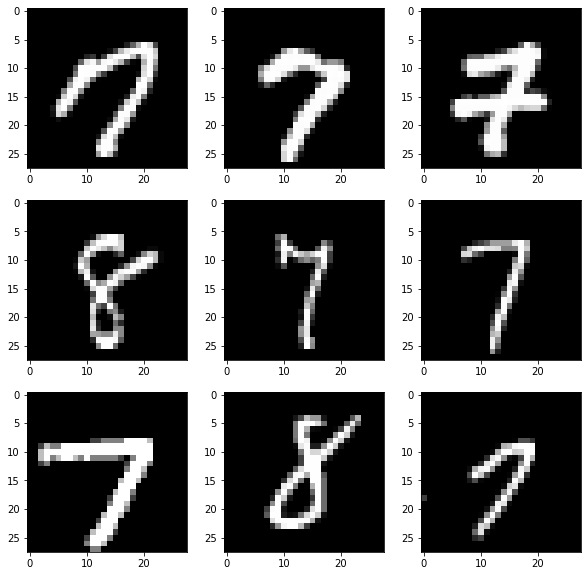

In [2]:
# MNIST の読み込み
train = pd.read_csv("./sample_data/mnist_train_small.csv",dtype = np.float32)
train.rename(columns={'6': 'label'}, inplace=True)
test = pd.read_csv("./sample_data/mnist_test.csv",dtype = np.float32)
test.rename(columns={'7': 'label'}, inplace=True)

# 学習データとして、7 と 8 の画像を合わせて400枚使用する
train = train.query("label in [7.0, 8.0]").head(400)

# テストデータとして、2, 7, 8 の画像を合わせて600枚使用する
test = test.query("label in [2.0, 7.0, 8.0]").head(600)

# ラベル(1列目)を削除
train = train.iloc[:,1:].values.astype('float32')
test = test.iloc[:,1:].values.astype('float32')

# 28×28 の行列に変換
train = train.reshape(train.shape[0], 28, 28)
test = test.reshape(test.shape[0], 28, 28)

# データの確認
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(330 + (i+1))
    plt.imshow(train[i], cmap=plt.get_cmap('gray'))

#### EGBAD
論文: https://arxiv.org/pdf/1802.06222.pdf

In [3]:
class Generator(nn.Module):

  def __init__(self):
    super(Generator, self).__init__()

    def CBA(in_channel, out_channel, kernel_size=4, stride=2, padding=1, activation=nn.ReLU(inplace=True), bn=True):
        seq = []
        seq += [nn.ConvTranspose2d(in_channel, out_channel, kernel_size=kernel_size, stride=stride, padding=padding)]
        if bn is True:
          seq += [nn.BatchNorm2d(out_channel)]
        seq += [activation]

        return nn.Sequential(*seq)

    seq = []
    seq += [CBA(20, 64*8, stride=1, padding=0)]
    seq += [CBA(64*8, 64*4)]
    seq += [CBA(64*4, 64*2)]
    seq += [CBA(64*2, 64)]
    seq += [CBA(64, 1, activation=nn.Tanh(), bn=False)]

    self.generator_network = nn.Sequential(*seq)

  def forward(self, z):
      out = self.generator_network(z)

      return out

In [4]:
class Discriminator(nn.Module):

  def __init__(self):
    super(Discriminator, self).__init__()

    def CBA(in_channel, out_channel, kernel_size=4, stride=2, padding=1, activation=nn.LeakyReLU(0.1, inplace=True)):
        seq = []
        seq += [nn.Conv2d(in_channel, out_channel, kernel_size=kernel_size, stride=stride, padding=padding)]
        seq += [nn.BatchNorm2d(out_channel)]
        seq += [activation]

        return nn.Sequential(*seq)

    seq = []
    seq += [CBA(1, 64)]
    seq += [CBA(64, 64*2)]
    seq += [CBA(64*2, 64*4)]
    seq += [CBA(64*4, 64*8)]
    seq += [nn.Conv2d(64*8, 512, kernel_size=4, stride=1)]
    self.feature_network = nn.Sequential(*seq)

    seq = []
    seq += [nn.Linear(20, 512)]
    seq += [nn.BatchNorm1d(512)]
    seq += [nn.LeakyReLU(0.1, inplace=True)]
    self.latent_network = nn.Sequential(*seq)

    self.critic_network = nn.Linear(1024, 1)

  def forward(self, x, z):
      feature = self.feature_network(x)
      feature = feature.view(feature.size(0), -1)
      latent = self.latent_network(z)

      out = self.critic_network(torch.cat([feature, latent], dim=1))

      return out, feature

In [5]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()

    def CBA(in_channel, out_channel, kernel_size=4, stride=2, padding=1, activation=nn.LeakyReLU(0.1, inplace=True)):
        seq = []
        seq += [nn.Conv2d(in_channel, out_channel, kernel_size=kernel_size, stride=stride, padding=padding)]
        seq += [nn.BatchNorm2d(out_channel)]
        seq += [activation]

        return nn.Sequential(*seq)

    seq = []
    seq += [CBA(1, 64)]
    seq += [CBA(64, 64*2)]
    seq += [CBA(64*2, 64*4)]
    seq += [CBA(64*4, 64*8)]
    seq += [nn.Conv2d(64*8, 512, kernel_size=4, stride=1)]
    self.feature_network = nn.Sequential(*seq)

    self.embedding_network = nn.Linear(512, 20)

  def forward(self, x):
    feature = self.feature_network(x).view(-1, 512)
    z = self.embedding_network(feature)

    return z

#### モデルの学習

In [6]:
class image_data_set(Dataset):
    def __init__(self, data):
        self.images = data[:,:,:,None]
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(64, interpolation=Image.BICUBIC),
            transforms.Normalize((0.1307,), (0.3081,))
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.transform(self.images[idx])

train_set = image_data_set(train)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [7]:
# GPU or CPU の指定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# モデルの読み込み
E = Encoder().to(device)
G = Generator().to(device)
D = Discriminator().to(device)

# モデルを学習モードに設定
E.train()
G.train()
D.train()

# オプティマイザの設定
optimizerE = torch.optim.Adam(E.parameters(), lr=0.0001, betas=(0.0, 0.9))
optimizerG = torch.optim.Adam(G.parameters(), lr=0.0001, betas=(0.0, 0.9))
optimizerD = torch.optim.Adam(D.parameters(), lr=0.0004, betas=(0.0, 0.9))

# 学習時の損失関数の定義
criterion = nn.BCEWithLogitsLoss(reduction='mean')

1. Generatorで潜在変数から偽の画像を作る
2. Encoderで本物の画像から潜在変数を作る
3. 潜在変数と画像を本物・偽物に分類できるようにDiscriminatorを学習
4. Generatorで潜在変数から偽の画像を作る
5. Discriminatorの分類結果が誤るようにGeneratorを学習
6. Encoderで本物の画像から潜在変数を作る
7. Discriminatorの分類結果が誤るようにEncoderを学習

In [8]:
# 学習の実行
for epoch in range(300):
  # 損失の推移を確認するための変数を定義
  log_e_loss, log_g_loss, log_d_loss = 0.0, 0.0, 0.0
  for images in train_loader:
    images = images.to(device)

    ## Discriminatorの学習
    # 真偽のラベルを定義
    label_real = torch.full((images.size(0),), 1.0).to(device)
    label_fake = torch.full((images.size(0),), 0.0).to(device)

    # Generatorを用いて潜在変数から偽の画像を生成
    z = torch.randn(images.size(0), 20).to(device).view(images.size(0), 20, 1, 1).to(device)
    fake_images = G(z)

    # Encoderを用いて本物の画像から潜在変数を生成
    z_real = E(images)

    # Discriminatorで偽の画像と本物の画像を判定
    d_out_real, _ = D(images, z_real)
    d_out_fake, _ = D(fake_images, z.view(images.size(0), 20))

    # 損失の計算
    d_loss_real = criterion(d_out_real.view(-1), label_real)
    d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
    d_loss = d_loss_real + d_loss_fake

    # 誤差逆伝播法で勾配の計算、重みの更新
    optimizerD.zero_grad()
    d_loss.backward()
    optimizerD.step()

    ## Generatorの学習
    # 潜在変数から偽の画像を生成
    z = torch.randn(images.size(0), 20).to(device).view(images.size(0), 20, 1, 1).to(device)
    fake_images = G(z)

    # Discriminatorによって真偽判定
    d_out_fake, _ = D(fake_images, z.view(images.size(0), 20))

    # 損失の計算
    g_loss = criterion(d_out_fake.view(-1), label_real)

    # 誤差逆伝播法で勾配の計算、重みの更新
    optimizerG.zero_grad()
    g_loss.backward()
    optimizerG.step()

    ## Encoderの学習
    # 真の画像から潜在変数を生成
    z_real = E(images)

    # Discriminatorによって真偽判定
    d_out_real, _ = D(images, z_real)

    e_loss = criterion(d_out_real.view(-1), label_fake)

    # 誤差逆伝播法で勾配の計算、重みの更新
    optimizerE.zero_grad()
    e_loss.backward()
    optimizerE.step()

    ## 損失の推移の記録
    log_d_loss += d_loss.item()
    log_g_loss += g_loss.item()
    log_e_loss += e_loss.item()

  print(f'epoch {epoch}, D_Loss:{log_d_loss/128:.4f}, G_Loss:{log_g_loss/128:.4f}, E_Loss:{log_e_loss/128:.4f}')

epoch 0, D_Loss:0.0936, G_Loss:0.2168, E_Loss:0.2118
epoch 1, D_Loss:0.0911, G_Loss:0.3994, E_Loss:0.2266
epoch 2, D_Loss:0.0085, G_Loss:0.2680, E_Loss:0.3118
epoch 3, D_Loss:0.0012, G_Loss:0.2248, E_Loss:0.2574
epoch 4, D_Loss:0.0008, G_Loss:0.2333, E_Loss:0.2553
epoch 5, D_Loss:0.0005, G_Loss:0.2410, E_Loss:0.2464
epoch 6, D_Loss:0.0003, G_Loss:0.2714, E_Loss:0.2650
epoch 7, D_Loss:0.0002, G_Loss:0.2662, E_Loss:0.2705
epoch 8, D_Loss:0.0003, G_Loss:0.2432, E_Loss:0.2878
epoch 9, D_Loss:0.1922, G_Loss:0.6642, E_Loss:0.4086
epoch 10, D_Loss:0.0005, G_Loss:0.4171, E_Loss:0.7011
epoch 11, D_Loss:0.0025, G_Loss:1.0378, E_Loss:0.5853
epoch 12, D_Loss:0.0002, G_Loss:0.5279, E_Loss:0.5741
epoch 13, D_Loss:0.1602, G_Loss:1.0291, E_Loss:0.4083
epoch 14, D_Loss:0.0051, G_Loss:0.8372, E_Loss:0.4396
epoch 15, D_Loss:0.0007, G_Loss:0.7325, E_Loss:0.3631
epoch 16, D_Loss:0.1250, G_Loss:0.8846, E_Loss:0.3052
epoch 17, D_Loss:0.0112, G_Loss:0.6628, E_Loss:0.3236
epoch 18, D_Loss:0.0010, G_Loss:0.5529

#### 精度検証

In [9]:
def anomaly_score(input_image, fake_image, z_real, D):
  # Residual loss の計算
  residual_loss = torch.sum(torch.abs(input_image - fake_image), (1, 2, 3))

  # Discrimination loss の計算
  _, real_feature = D(input_image, z_real)
  _, fake_feature = D(fake_image, z_real)
  discrimination_loss = torch.sum(torch.abs(real_feature - fake_feature), (1))

  # 二つのlossを一定の割合で足し合わせる
  total_loss_by_image = 0.9 * residual_loss + 0.1 * discrimination_loss

  return total_loss_by_image

[464165.03 363841.9  251786.47 419337.66 471160.9 ]


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


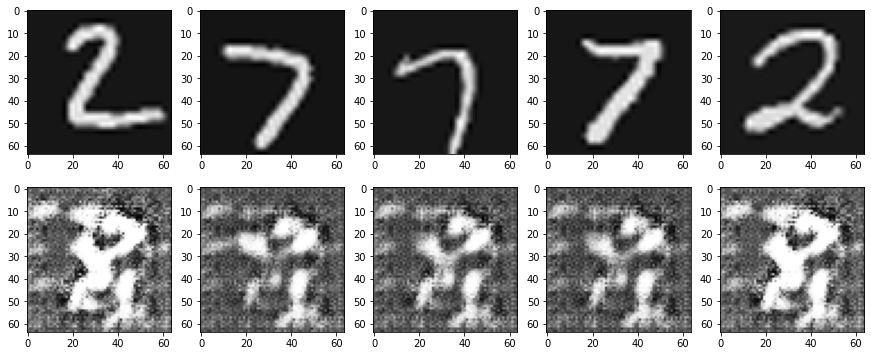

In [10]:
# データローダの読み込みと画像の取得
test_set = image_data_set(test)
test_loader = DataLoader(test_set, batch_size=5, shuffle=False)
input_images = next(iter(test_loader)).to(device)

# Encoderにより潜在変数を取得、その潜在変数を基にGeneratorで画像を再構成
z_real = E(input_images)
fake_images = G(z_real.view(input_images.size(0), 20, 1, 1))

# 異常度の計算
anomality = anomaly_score(input_images, fake_images, z_real, D)

print(anomality.cpu().detach().numpy())
plt.figure(figsize=(15, 6))
for i in range(5):
  plt.subplot(2, 5, i+1)
  plt.imshow(input_images[i][0].cpu().detach().numpy(), 'gray')

  plt.subplot(2, 5, 5+i+1)
  plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')